In [2]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Lung Cancer Classification using CNN

> Author: Sebastián Čambál (2022)

### Dataset

Link: https://www.kaggle.com/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset

Data source reference: Alyasriy, Hamdalla; AL-Huseiny, Muayed (2021), “The IQ-OTHNCCD lung cancer dataset”, Mendeley Data, V2, [DOI: 10.17632/bhmdr45bh2.2](https://data.mendeley.com/datasets/bhmdr45bh2/2)

The IQ-OTH/NCCD lung cancer dataset, 157 MB of CT scan slices images in 3 classes: malignant, benign, normal.

Classification of lung cancer images into 3 classes: normal, malignant and benign cases.
We solve the task using a convolutional neural network (CNN).

>Note:
>- A CNN is the convolutional neural network is used here for image classification. Its convolutional layers perform feature extraction by applying kernels (filters) over the image. Formula for a convolution operation: (f * g)(t) = ∫ f(τ) g(t - τ)dτ.
>  Formula for convolution operation:
>  (f * g)(t) = ∫ f(τ) g(t - τ)dτ
>- Dropout is a regularization technique where a fraction of neurons is randomly ignored during training to reduce overfitting.
>- MaxPooling reduces spatial dimensions by taking the maximum value over a defined window.


In [3]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential

In [4]:
# image dimensions for resizing
IMAGE_SIZE = 256
# number of images per batch. batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.
BATCH_SIZE = 30

## EDA and data preprocessing

First, we will start with the visualization of CT scans.

>Note: The typo "bengin" is found instead of the word "benign" throughout the dataset.

In [ ]:
normal_imgs = [fn for fn in os.listdir(path='The IQ-OTHNCCD lung cancer dataset/Normal cases') if fn.endswith('.jpg')]
benign_imgs = [fn for fn in os.listdir(path='The IQ-OTHNCCD lung cancer dataset/Bengin cases') if fn.endswith('.jpg')]
malignant_imgs = [fn for fn in os.listdir(path='The IQ-OTHNCCD lung cancer dataset/Malignant cases') if fn.endswith('.jpg')]
print(f'num. normal: {len(normal_imgs)}, num. bengin: {len(benign_imgs)}, num. malignant: {len(malignant_imgs)}')

In [7]:
# randomly select 3 images from each class
normal_selection = np.random.choice(normal_imgs, 3, replace = False)
benign_selection = np.random.choice(benign_imgs, 3, replace = False)
malignant_selection = np.random.choice(malignant_imgs, 3, replace = False)

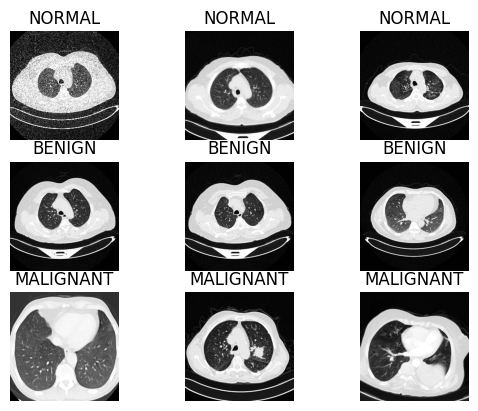

In [8]:
fig = plt.figure()
for i in range(9):
    if i < 3:
        fp = f'The IQ-OTHNCCD lung cancer dataset/Normal cases/{normal_selection[i]}'
        label = 'NORMAL'
    elif i>=3 and i < 6:
        fp = f'The IQ-OTHNCCD lung cancer dataset/Bengin cases/{benign_selection[i-3]}'
        label = 'BENIGN'
    else:
        fp = f'The IQ-OTHNCCD lung cancer dataset/Malignant cases/{malignant_imgs[i-6]}'
        label = 'MALIGNANT'
    ax = fig.add_subplot(3, 3, i+1)

    # load image with grayscale mode and resize; to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (IMAGE_SIZE,IMAGE_SIZE), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

In [9]:
def img2np(path, list_of_filename, size=(IMAGE_SIZE, IMAGE_SIZE)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, color_mode = 'grayscale')
        # convert image to an array (matrix)
        img_ts = image.img_to_array(current_image)
        # flatten image matrix into a 1d vector
        img_ts = [img_ts.ravel()]
        try:
            # concatenate images into a single matrix
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError:
            # assign first image if variable not defined
            full_mat = img_ts
    return full_mat

# convert images from each class into numpy arrays
normal = img2np('The IQ-OTHNCCD lung cancer dataset/Normal cases/', normal_imgs)
benign = img2np('The IQ-OTHNCCD lung cancer dataset/Bengin cases/', benign_imgs)
malignant = img2np('The IQ-OTHNCCD lung cancer dataset/Malignant cases/', malignant_imgs)

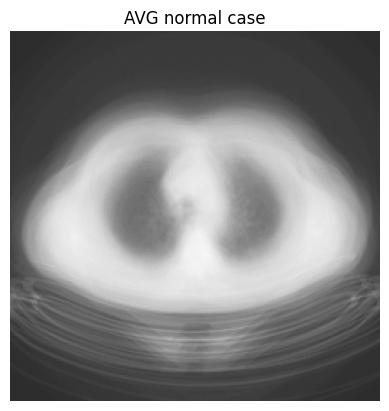

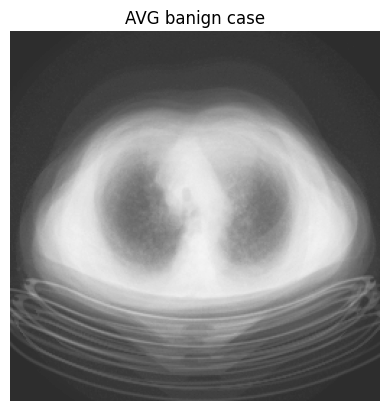

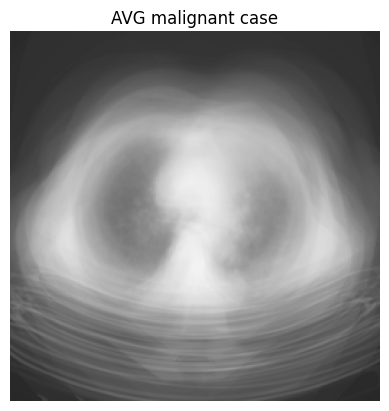

In [10]:
def find_mean_img(full_mat, title, size=(IMAGE_SIZE, IMAGE_SIZE)):
    # calculate the average image over all images (mean along axis 0)
    mean_img = np.mean(full_mat, axis = 0)

    # reshape the vector back into image matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'AVG {title} case')
    plt.axis('off')
    plt.show()
    return mean_img

# calculate and display the mean image for each class
norm_mean_img = find_mean_img(normal, 'normal')
benign_mean_img = find_mean_img(benign, 'banign')
malignant_mean_img = find_mean_img(malignant, 'malignant')

## Creating a dataset

We use the tensorflow keras function to load images directly from the directory structure.

In [11]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    'The IQ-OTHNCCD lung cancer dataset',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1097 files belonging to 3 classes.


In [12]:
classes = ds.class_names
print(f'classes for classification: {str(classes)}')

Classes for classification: ['Bengin cases', 'Malignant cases', 'Normal cases']


### Splitting the dataset

The dataset is split into training, validation, and testing sets.

In [13]:
def splitDataset(data, train_split=0.7, val_split=0.2, test_split=0.1):
    data_size = len(data)
    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = splitDataset(ds)

In [14]:
# determine input shape from a batch in training dataset
input_shape = None
for batch, labels in train_ds.take(1):
    input_shape = batch.shape
    print(input_shape)
    print(labels.numpy())

(30, 256, 256, 3)
[2 2 2 2 1 1 2 2 1 1 1 2 1 1 1 1 1 2 0 2 1 1 2 1 1 1 1 2 1 1]


2024-11-18 16:20:22.166361: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Creation and Training of the model

We build a convolutional neural network (CNN) model using keras Sequential API.

>Key components:
>- Convolutional layers: perform feature extraction using kernels.
>- MaxPooling: reduces spatial dimensions.
>- Dropout: prevents overfitting by randomly disabling neurons during training.
>- Dense layers: for classification with softmax activation.

In [16]:
model = Sequential([
    layers.Rescaling(1./255), # normalize pixel values to [0, 1] range
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape), # convolutional layer; relu introduces non-linearity
    layers.MaxPooling2D((2,2)), # pooling layer to reduce spatial dimensions
    layers.Dropout(0.3), # dropout for regularization
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'), # additional convolutional layer
    layers.MaxPooling2D((2,2)), # pooling layer; is used to reduce the spatial dimensions of the output volume
    layers.Flatten(),
    layers.Dropout(0.3), # dropout for regularization; randomly sets input units to 0 with a frequency of rate
    layers.Dense(32, activation='relu'), # dense layer for learning complex patterns
    layers.Dense(3, activation='softmax')  # output layer for 3 classes with softmax to get probabilities
])
model.build(input_shape=input_shape)

/Users/oleksandr.lytvyn/other/uni/iau/2024/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Here we use `Adam` optimizer and `SparseCategoricalCrossentropy` loss function for multi-class classification.

`Adam` is an adaptive learning rate optimization algorithm that's designed specifically for training deep neural networks.
_It's a first-order optimization method that's efficient and requires little memory_. More details: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

`SparseCategoricalCrossentropy` computes the crossentropy loss between the labels and predictions. Use this crossentropy loss function when there are two or more label classes. We expect labels to be provided as integers. More details: https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), # adam optimizer for adaptive learning rates
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (30, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (30, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (30, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (30, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (30, 125, 125, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (30, 62, 62, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (30, 123008)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (30, 123008)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (30, 32)               │     3,936,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (30, 3)                │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,946,531 (15.05 MB)

 Trainable params: 3,946,531 (15.05 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(train_ds, batch_size=BATCH_SIZE, epochs=6, validation_data=val_ds, validation_batch_size=BATCH_SIZE)

Epoch 1/6
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.3873 - loss: 3.3522 - val_accuracy: 0.4667 - val_loss: 1.0135
Epoch 2/6
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.5233 - loss: 0.9224 - val_accuracy: 0.5000 - val_loss: 0.9667
Epoch 3/6
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.5459 - loss: 0.8529 - val_accuracy: 0.4476 - val_loss: 0.9738
Epoch 4/6
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.5605 - loss: 0.7944 - val_accuracy: 0.6524 - val_loss: 0.7860
Epoch 5/6
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.6780 - loss: 0.6611 - val_accuracy: 0.7095 - val_loss: 0.7153
Epoch 6/6
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.7417 - loss: 0.5546 - val_accuracy: 0.8190 - val_loss: 0.5929


In [19]:
loss, acc = model.evaluate(val_ds, batch_size=BATCH_SIZE)
print(f'Loss: {round(loss, 3)}, Acc: {round(acc*100, 3)}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7949 - loss: 0.6043
Loss: 0.603, Acc: 79.524%


In [20]:
plt.figure(figsize=(8, 8))
plt.plot(range(6), history.history['val_loss'], label='Validation Loss')
plt.plot(range(6), history.history['loss'], label='Loss')
plt.title('Loss')
plt.legend()
plt.show()

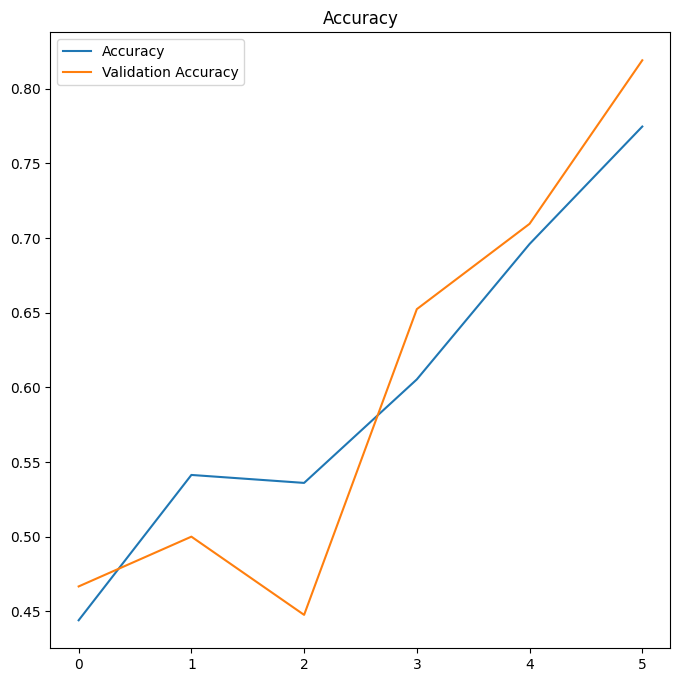

In [21]:
plt.figure(figsize=(8, 8))
plt.plot(range(6), history.history['accuracy'], label='Accuracy')
plt.plot(range(6), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

## Model testing

We perform testing on the test dataset and compare the predicted classes with the actual classes.

In [22]:
testing_labels = []
testing_batch = []

for batch, labels in test_ds.take(1):
    testing_labels = labels.numpy()
    testing_batch = batch

real_labels = [classes[x] for x in testing_labels]

2024-11-18 16:21:35.516776: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
predictions = model.predict(testing_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [24]:
output = []
for pred in predictions:
    output.append(classes[np.argmax(pred)])

In [25]:
predicted_data = pd.DataFrame({'predicion': output, 'real class': real_labels})
predicted_data

Predicion       Real class
0   Malignant cases  Malignant cases
1      Normal cases     Normal cases
2      Normal cases     Normal cases
3      Normal cases     Normal cases
4      Normal cases     Normal cases
5      Normal cases     Normal cases
6   Malignant cases  Malignant cases
7      Normal cases     Normal cases
8      Normal cases     Normal cases
9      Normal cases     Normal cases
10     Normal cases     Normal cases
11     Normal cases     Normal cases
12     Normal cases     Normal cases
13     Normal cases     Normal cases
14  Malignant cases  Malignant cases
15  Malignant cases  Malignant cases
16  Malignant cases  Malignant cases
17     Normal cases     Normal cases
18  Malignant cases  Malignant cases
19     Normal cases     Normal cases
20  Malignant cases  Malignant cases
21     Normal cases     Bengin cases
22  Malignant cases  Malignant cases
23     Normal cases     Normal cases
24  Malignant cases  Malignant cases
25  Malignant cases  Malignant cases
26     Normal cases     Normal cases
27     Normal cases     Normal cases
28     Normal cases     Normal cases
29     Normal cases     Normal cases